In [49]:
from splinter import Browser
from bs4 import BeautifulSoup as bs
import time
from webdriver_manager.chrome import ChromeDriverManager
import pymongo
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
 # Set up Splinter
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)

# Visit Mars Temperature Data page
url = "https://data-class-mars-challenge.s3.amazonaws.com/Mars/index.html"
browser.visit(url)


[WDM] - Downloading: 100%|██████████| 6.29M/6.29M [00:04<00:00, 1.60MB/s]


In [3]:
html = browser.html
soup = bs(html, "html.parser")
tbl = soup.find('table', class_='table')

In [4]:
# Extract the column names
col_names = tbl.find_all('th')
col_names_list = {}
i = 0
for c in col_names:
    i+=1
    col_names_list[str(i)]= c.text

In [5]:
print(col_names_list)

{'1': 'id', '2': 'terrestrial_date', '3': 'sol', '4': 'ls', '5': 'month', '6': 'min_temp', '7': 'pressure'}


In [6]:
# Intialize lists
id = []
terr_date = []
sol = []
ls = []
month = []
min_temp = []
pressure = []
# Extract all the data rows
data_rows = tbl.find_all('tr', class_='data-row')
# Store into it's specific column
for r in data_rows:
    td_val = r.find_all('td')
    id.append(td_val[0].text)
    terr_date.append(datetime.strptime(td_val[1].text, '%Y-%m-%d').date())
    sol.append(int(td_val[2].text))
    ls.append(int(td_val[3].text))
    month.append(int(td_val[4].text))
    min_temp.append(float(td_val[5].text))
    pressure.append(float(td_val[6].text))

In [7]:
browser.quit()

In [84]:
print(id[0:5])
len(id)

['2', '13', '24', '35', '46']


1867

In [85]:
print(terr_date[0:5])
len(terr_date)

[datetime.date(2012, 8, 16), datetime.date(2012, 8, 17), datetime.date(2012, 8, 18), datetime.date(2012, 8, 19), datetime.date(2012, 8, 20)]


1867

In [86]:
print(pressure[0:5])
len(pressure)

[739.0, 740.0, 741.0, 732.0, 740.0]


1867

In [8]:
# Save into DataFrame
df = pd.DataFrame({'1':id, '2':terr_date, '3':sol, '4':ls, '5':month, '6':min_temp, '7':pressure})
df = df.rename(columns=col_names_list)

In [9]:
df.head()

,id,terrestrial_date,sol,ls,month,min_temp,pressure
0,2,2012-08-16,10,155,6,-75.0,739.0
1,13,2012-08-17,11,156,6,-76.0,740.0
2,24,2012-08-18,12,156,6,-76.0,741.0
3,35,2012-08-19,13,157,6,-74.0,732.0
4,46,2012-08-20,14,157,6,-74.0,740.0


In [89]:
df.dtypes

id                   object
terrestrial_date     object
sol                   int64
ls                    int64
month                 int64
min_temp            float64
pressure            float64
dtype: object

## Data Analysis Questions
<strong>How many months exist on Mars?</strong>

In [92]:
len(df['month'].unique())

12

There are 12 months on Mars.<br><br>

<strong>How many Martian (and not Earth) days worth of data exist in the scraped dataset?</strong>

In [92]:
df['sol'].max() - df['sol'].min()

1967

The data holds 1967 Martian days worth of data.<br><br>

<strong>What are the coldest and the warmest months on Mars (at the location of Curiosity)? Get the answer by averaging the minimum daily temperature of all the months. Plot the results as a bar chart.</strong>

In [113]:
month_grp = df.groupby('month')
avg_temp = month_grp[['month','min_temp']].mean('min_temp')
avg_temp

,month,min_temp
month,,
1,1.0,-77.160920
2,2.0,-79.932584
3,3.0,-83.307292
4,4.0,-82.747423
5,5.0,-79.308725
6,6.0,-75.299320
7,7.0,-72.281690
8,8.0,-68.382979
9,9.0,-69.171642


<AxesSubplot:title={'center':'Average Temperature on Mars per Month'}, xlabel='month', ylabel='Temperature (Celsius)'>

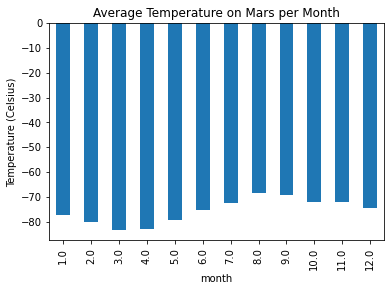

In [110]:
avg_temp.plot.bar(x='month', y='min_temp', title='Average Temperature on Mars per Month', ylabel='Temperature (Celsius)', legend = False)


The coldest month is March with -83.31 Celsius as it's average temperature. The warmest month is in August with it's average temperature at -68.38 Celsius.<br><br>

<strong>Which months have the lowest and highest atmospheric pressure on Mars? (Average the daily atmospheric pressure of all the months). Plot as a bar chart.</strong>

In [114]:
avg_pressure = month_grp[['month', 'pressure']].mean('pressure')
avg_pressure

,month,pressure
month,,
1,1.0,862.488506
2,2.0,889.455056
3,3.0,877.322917
4,4.0,806.329897
5,5.0,748.557047
6,6.0,745.054422
7,7.0,795.105634
8,8.0,873.829787
9,9.0,913.305970


<AxesSubplot:title={'center':'Average Pressure on Mars per Month'}, xlabel='month', ylabel='Pressure'>

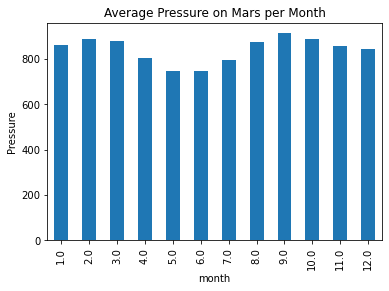

In [115]:
avg_pressure.plot.bar(x='month', y='pressure', title='Average Pressure on Mars per Month', ylabel = 'Pressure', legend=False)

September has the highest atmospheric pressure at 913.305. June has the lowest pressure at 745.054.<br><br>

<strong>About how many terrestrial Earth days exist in a Martian year? (In the time that Mars circles the Sun once, how many days elapse on Earth?) Visually estimate the result by plotting the daily minimum temperature.</strong>

<AxesSubplot:xlabel='terrestrial_date', ylabel='min_temp'>

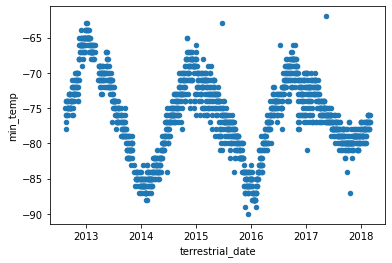

In [116]:
df.plot.scatter(x='terrestrial_date', y='min_temp')

In [70]:
# Find the lowest temperature in 2014
low_df = df[(df['terrestrial_date'] > datetime(2013, 1, 1).date()) & (df['terrestrial_date'] < datetime(2015, 1, 1).date())]
low_df['min_temp'].min()

-88.0

In [75]:
# find the date of the row with the lowest temperature
low_id = low_df['terrestrial_date'].loc[low_df['min_temp'] == low_df['min_temp'].min()]
low_id

452    2014-02-03
455    2014-02-06
Name: terrestrial_date, dtype: object

In [85]:
# Find the lowest temperature in 2015
low_df_2015 = df[(df['terrestrial_date'] > datetime(2014, 12, 1).date()) & (df['terrestrial_date'] < datetime(2016, 1, 1).date())]
low_df_2015['min_temp'].min()


-90.0

In [87]:
# find the date of the row with the highest temperature
low_date_2015 = low_df_2015['terrestrial_date'].loc[low_df_2015['min_temp'] == low_df_2015['min_temp'].min()]
low_date_2015

1093    2015-12-09
Name: terrestrial_date, dtype: object

In [89]:
df_year = df[(df['terrestrial_date'] <= datetime(2015, 12, 9).date()) & (df['terrestrial_date'] >= datetime(2014, 2, 6).date())]
len(df_year)

639

(array([16161., 16252., 16344., 16436., 16526., 16617., 16709., 16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

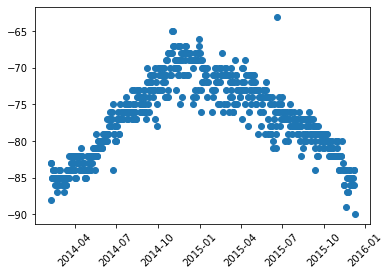

In [90]:
plt.scatter(x=df_year['terrestrial_date'], y=df_year['min_temp'])
plt.xticks(rotation=45)

There are approximately 639 Earth days in one Martian year. This would found by counting the number of Earth days in one peak in the chart for the minimum temperatures on Mars. The increase and decrease in temperature is used to determine where Mars is during it's orbit around the sun. The closer it is, the higher it's temperature representing Summer on Earth; conversely, the lower the temperature, the further away Mars is from the sun which can be seen as Winter on Earth.

In [91]:
# Export data as CSV
df.to_csv('mars_temp.csv')
